In [13]:
# Import the packages I will be using
import pandas as pd
import numpy as np
# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import missingno

import matplotlib.pyplot as plt
# Read the csv file
titanic = pd.read_csv("titanic.csv")

# Get a quick glance at the data
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# I was unsure of what a few columns meant, from a quick google search:
# - SibSp - no of siblings/spouse aboard
# - Parch - no of parents/children aboard
# - Embarked - C = Cherbourg, Q = Queenstown, S = Southampton

In [14]:
missing_data = titanic.isnull().sum()
missing_data[0:12]
# Most of the data is not missing. 
# Cabin has a lot of missing values, however, I don't have enough info on the location of the cabins and could potentially ignore this column.
# Age is the second column with most missing values. This could be an issue especially if we are trying to determine how many children were saved.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
# How many survived

survived = titanic.Survived[titanic["Survived"] == 1].count()
perished = titanic.Survived[titanic["Survived"] == 0].count()

print( 'Survived = ', survived,'Perished = ', perished)

# The majority perished

Survived =  342 Perished =  549


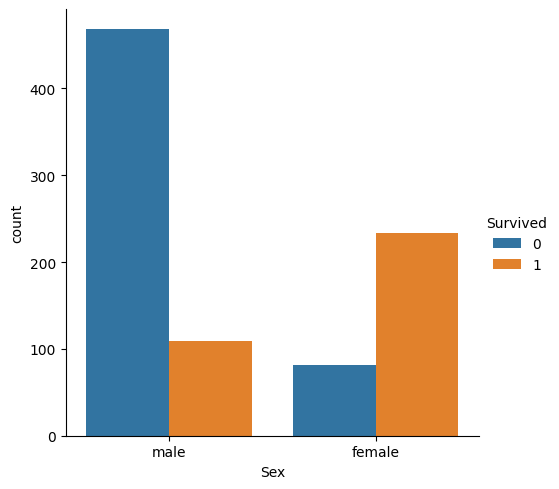

In [20]:
# To investigate what determined survival, I will look at:
# - survival and sex
# - survival and Pclass
# - survival and age (with caution as I have 177 missing data points)
# - survival and fare

# Survival and sex
sns.catplot(data=titanic, x="Sex", hue="Survived", kind="count")
# We can that a significantly larger propertion of males did not survive whilst a significantly higher proportion of women did.
# This supports the women first

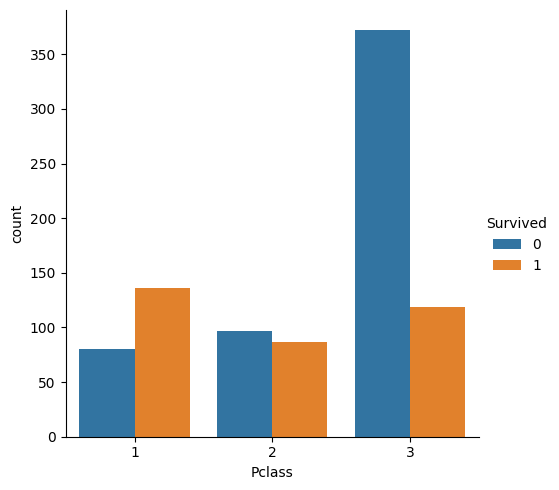

In [21]:
# survival and Pclass
sns.catplot(data=titanic, x="Pclass", hue="Survived", kind="count")

# We can see the majority of passengers were in 3rd class and a significantly higher proportion of them perished
# The majority of first class passengers survived
# Within second class, about equal amounts survived and perished.
# It appears that the upper class were given preference to improve their chances of survival.


<AxesSubplot: xlabel='Survived', ylabel='Pclass'>

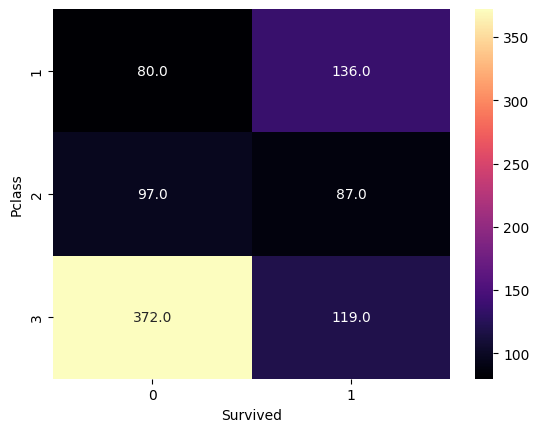

In [31]:
# Survival and class heat map
heat = titanic.groupby(['Pclass', 'Survived'])
class_survived = heat.size().unstack()

# annot = True to annotate the map
# fmt = .1f to avoid the values being written using e

sns.heatmap(class_survived, annot = True, fmt =".1f", cmap="magma")

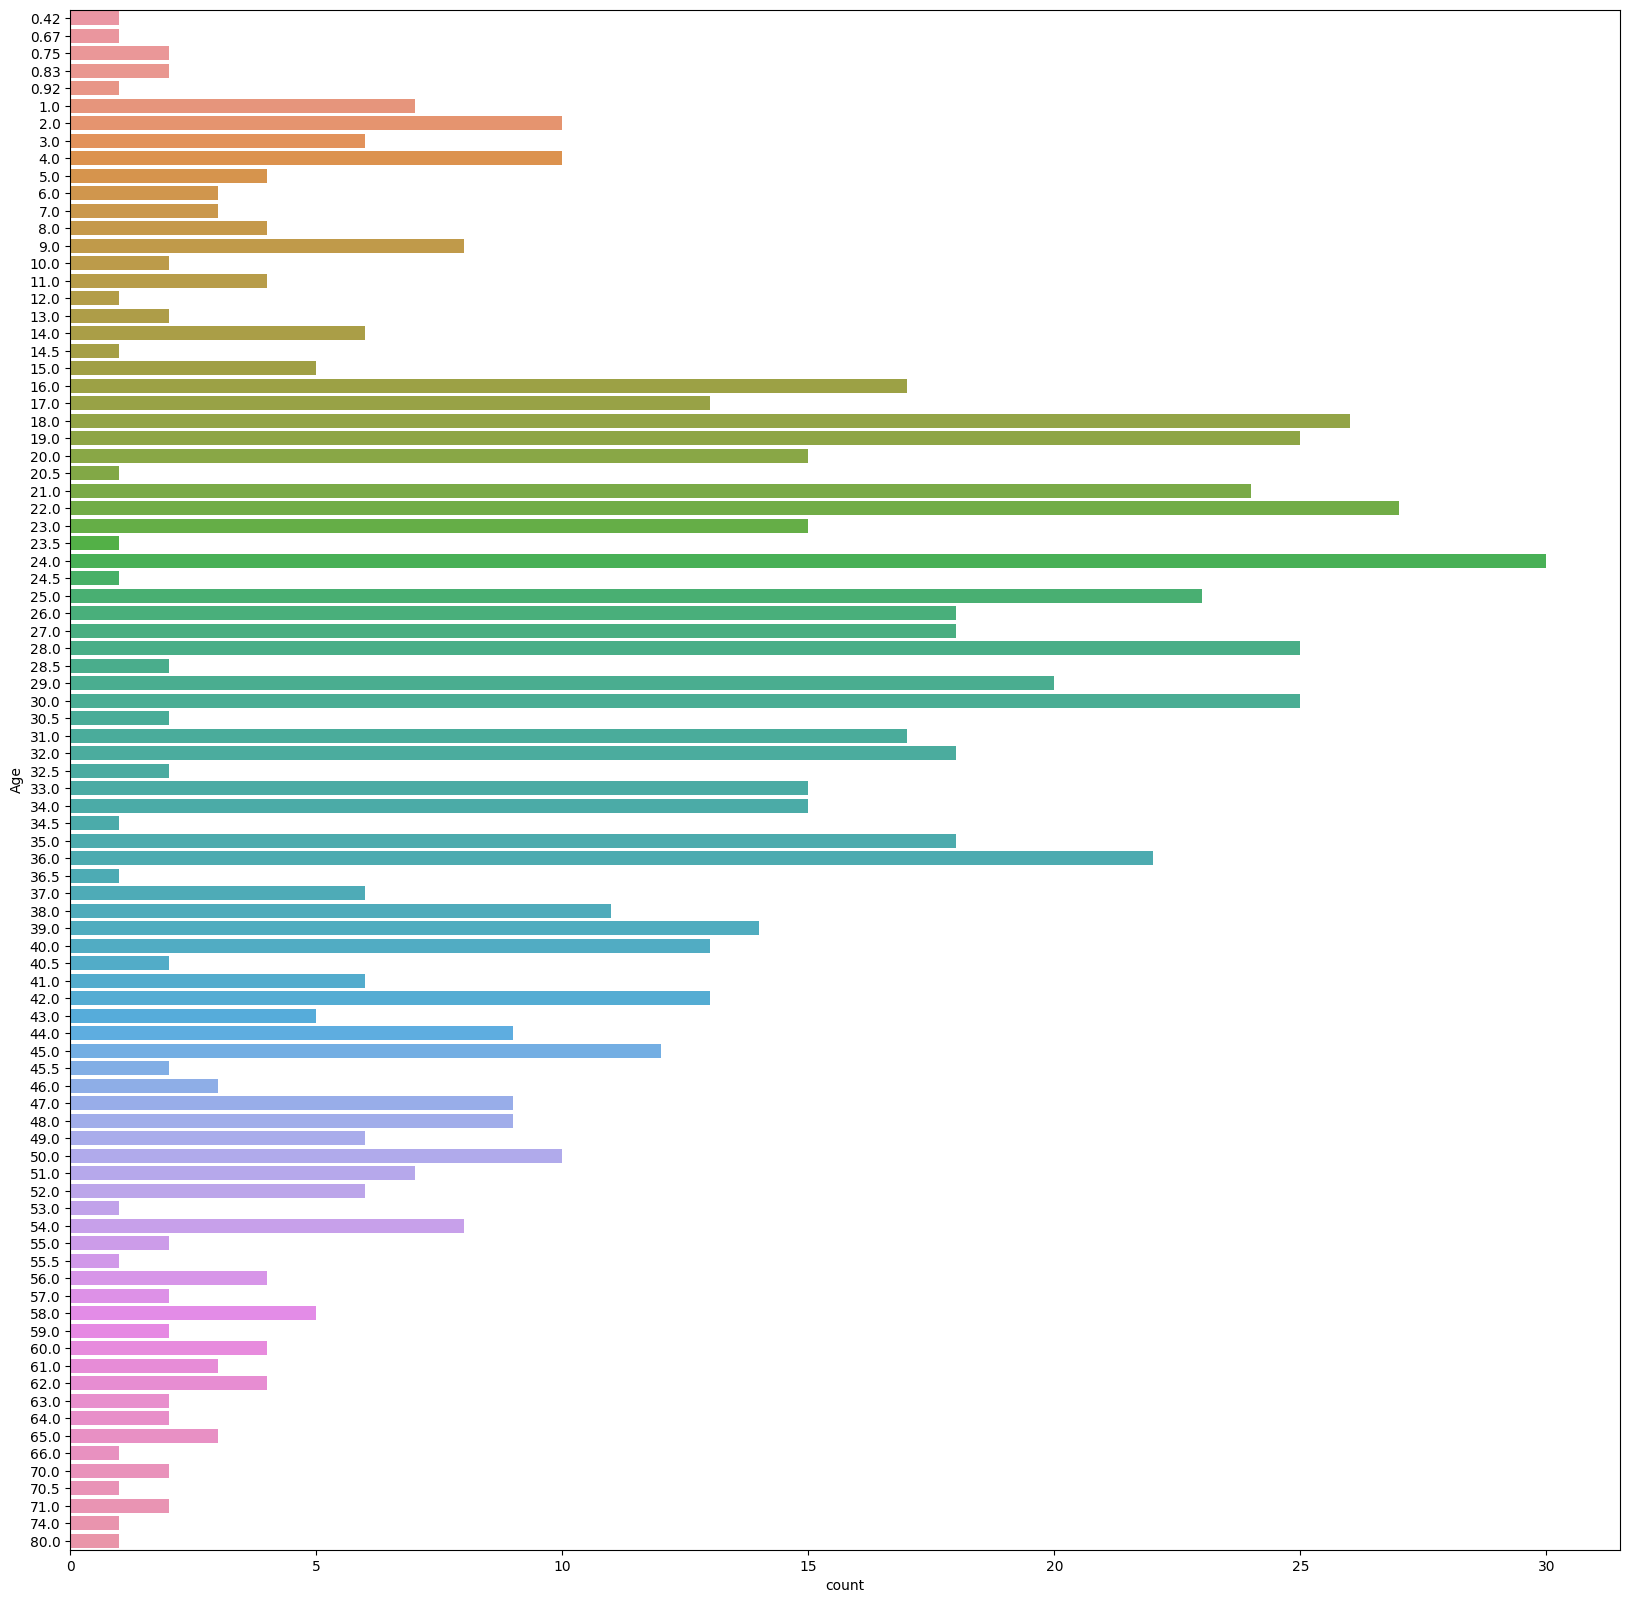

In [34]:

# I first need to organise the data before I can look at the relationship between survival and age

# First exclude all the data with missing age values
with_ages = titanic.dropna(subset="Age")

# Need the next line to make the graph large enough to read
fig = plt.figure(figsize=(20,20))

# Using the line of code:
sns.countplot(y=with_ages['Age'], data=with_ages)
# I found that the ages go from 0 to 80 and that I should rather group them


C:\Users\samwilson\AppData\Local\Temp\ipykernel_6192\555167301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_ages['Age_group'] = pd.cut(with_ages['Age'], [0,10,20,30,40,50,60,70,80],


<AxesSubplot: xlabel='count', ylabel='Age_group'>

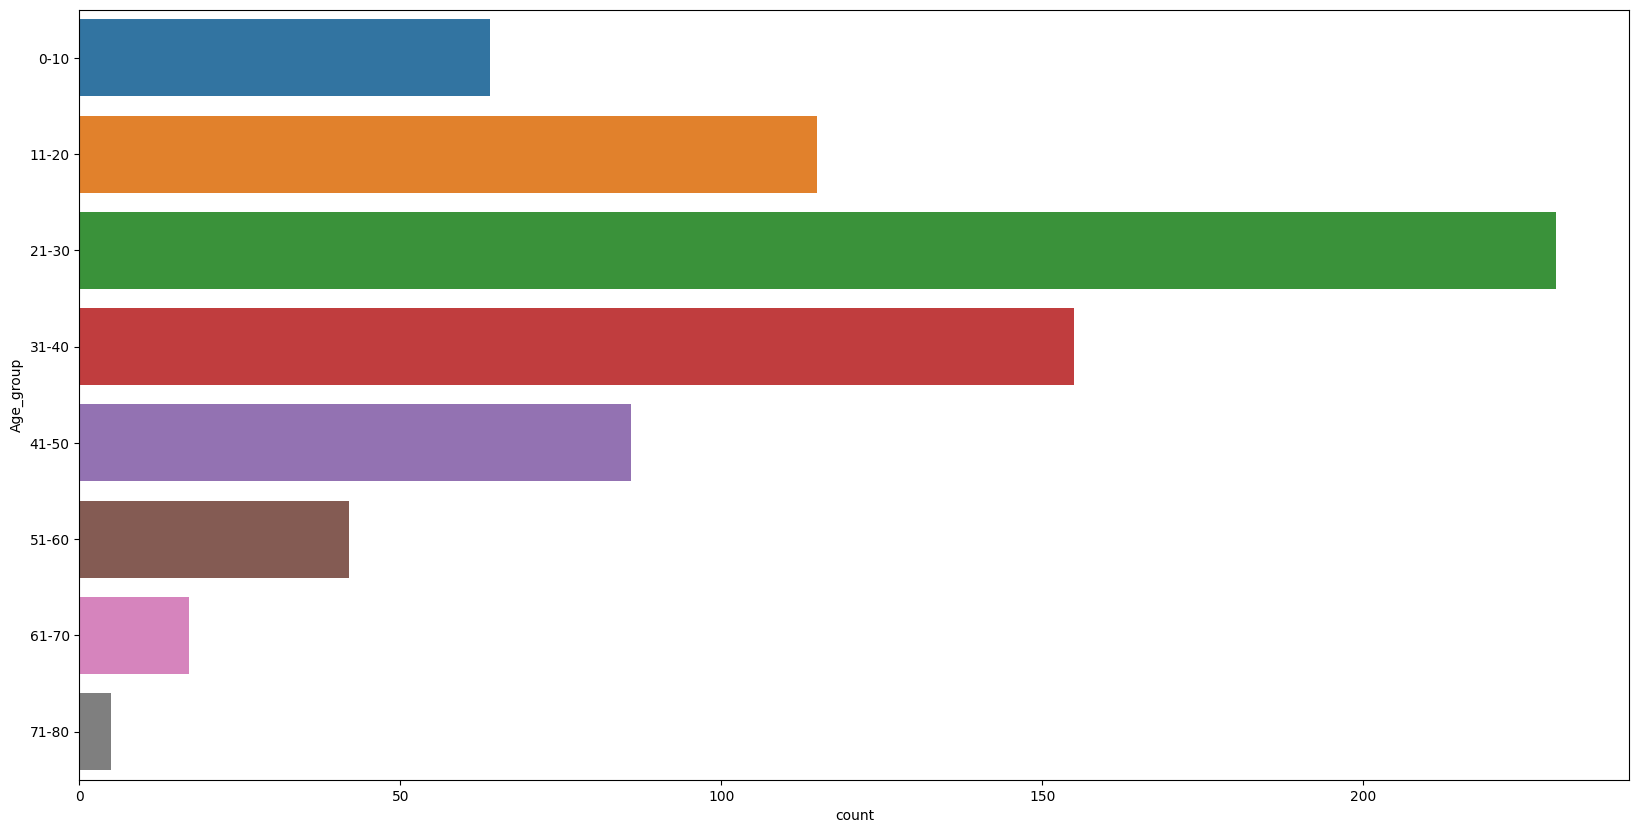

In [35]:
with_ages['Age_group'] = pd.cut(with_ages['Age'], [0,10,20,30,40,50,60,70,80], 
                   labels=['0-10', '11-20', '21-30','31-40','41-50','51-60',
                           '61-70','71-80'])

fig = plt.figure(figsize=(20,10))
sns.countplot(y=with_ages['Age_group'], data=with_ages)

# We can see that the majority of passengers are aged between 11 and 40.


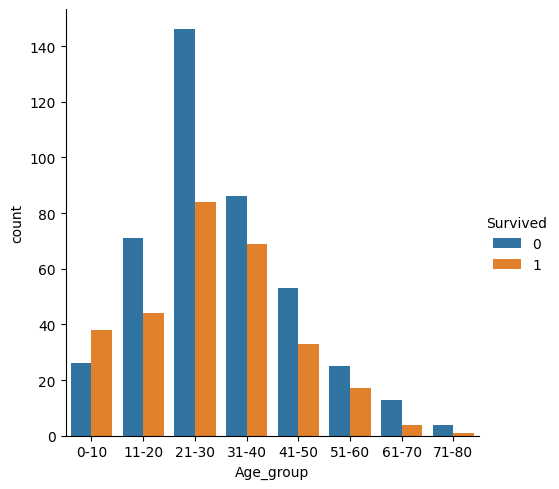

In [36]:
# Survival and age
sns.catplot(data=with_ages, x="Age_group", hue="Survived", kind="count")

# The only group where a larger proportion survived was the 0 - 10 group. Caveat: missing ages
# This supports the children first

<AxesSubplot: xlabel='count', ylabel='Fare'>

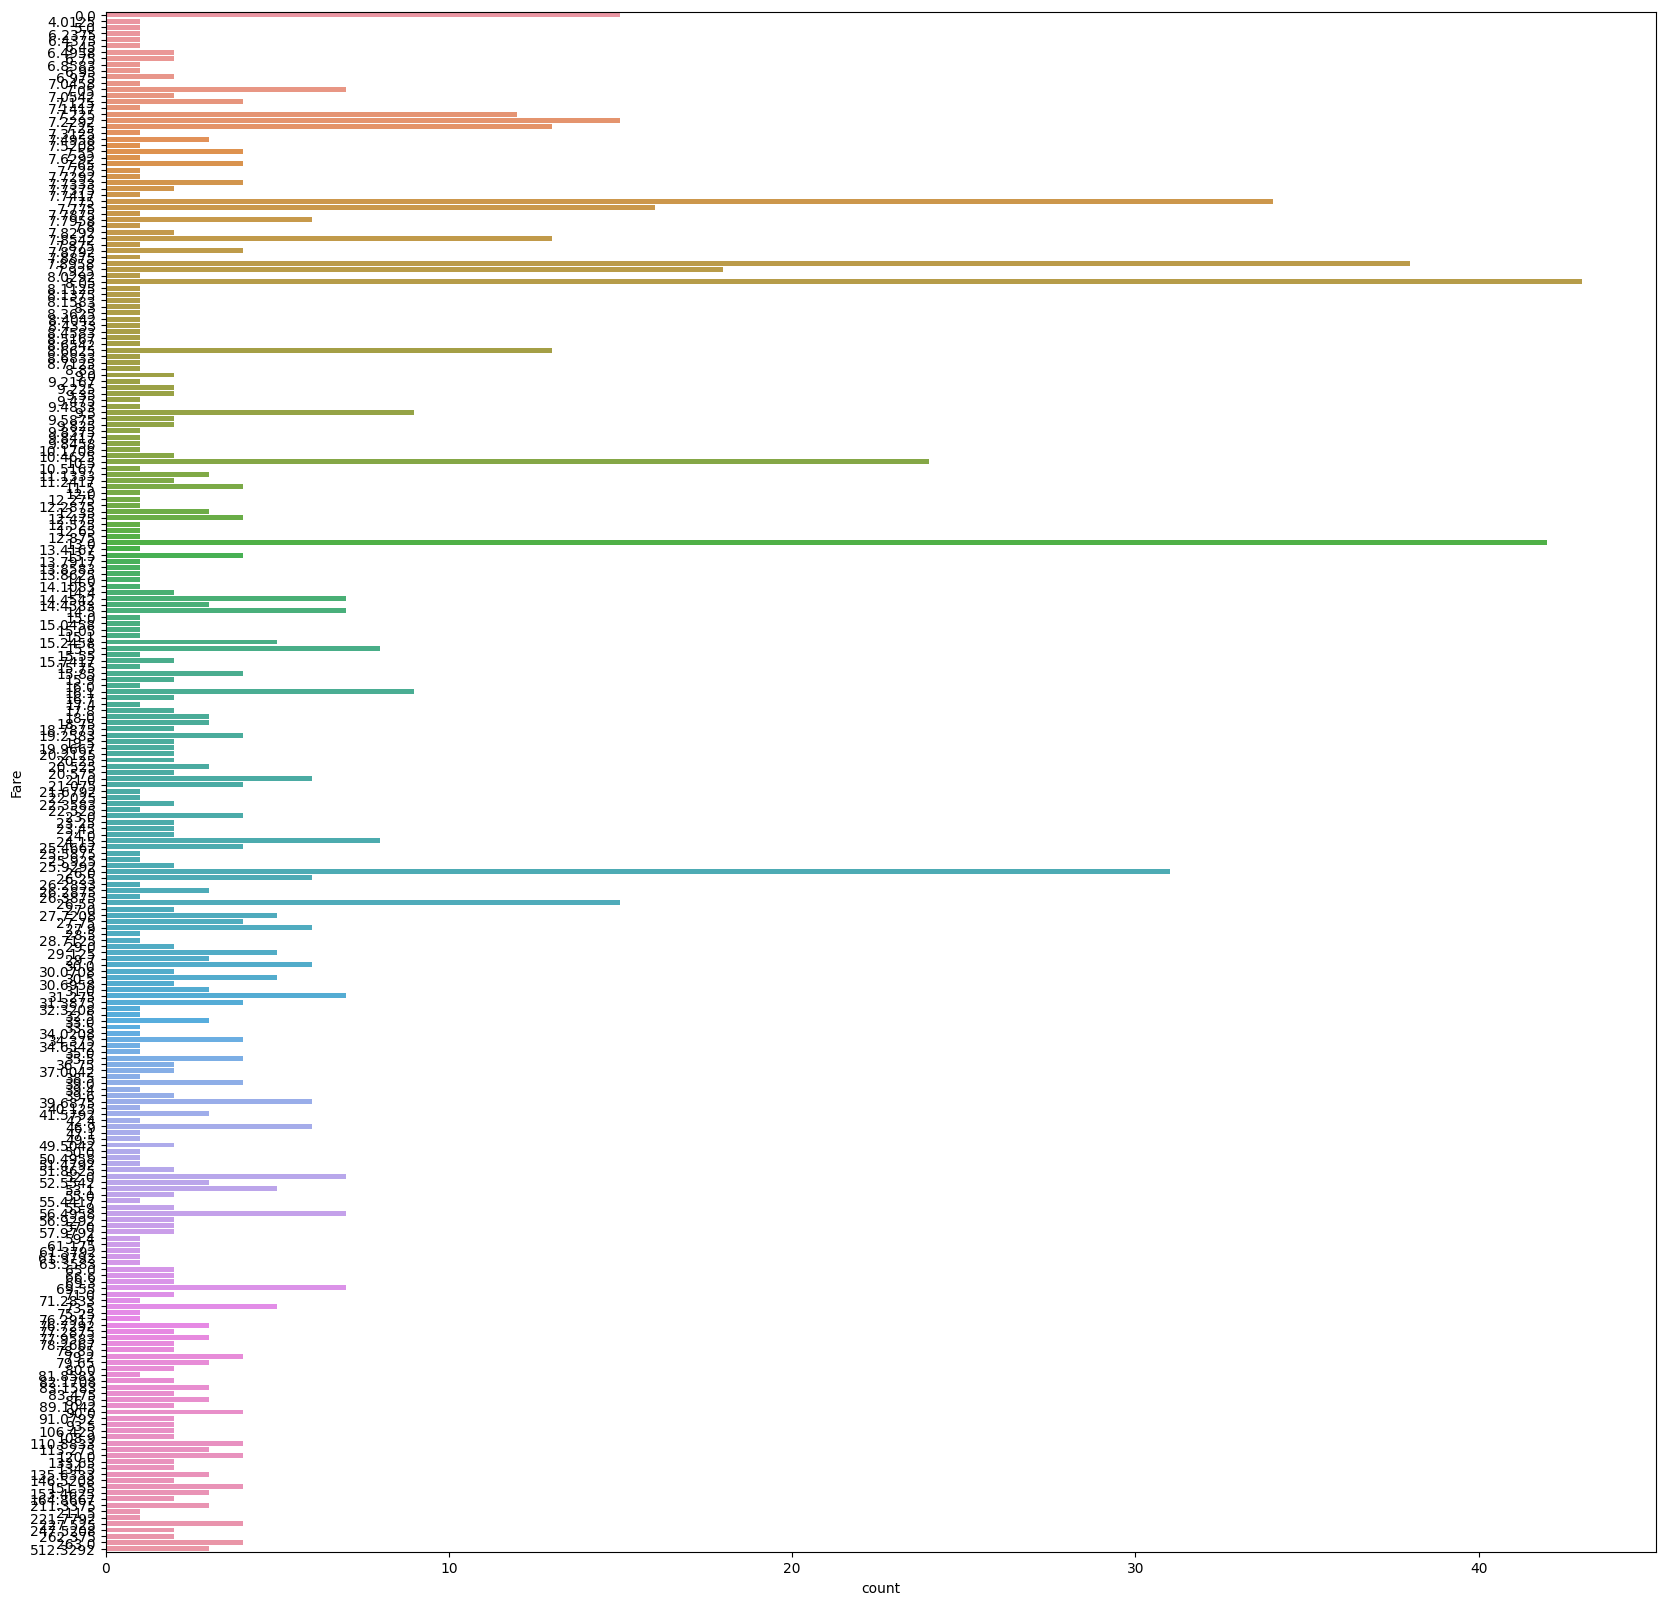

In [37]:
# I first need to organise the data before I can look at the relationship between fare and survival

# Need the next line to make the graph large enough to read
fig = plt.figure(figsize=(20,20))

# Using the line of code:
sns.countplot(y=titanic['Fare'], data=titanic)
# I found that the ages go from 0 to 513. There is a big jump from 262 to 512. There are fewer than 5 fares that have a value of 512
# I think I should remove them as they could be outliers, 
# however they may be the super extravagant rooms and I don't have enough confidence to exclude them.

<AxesSubplot: xlabel='count', ylabel='Fare_group'>

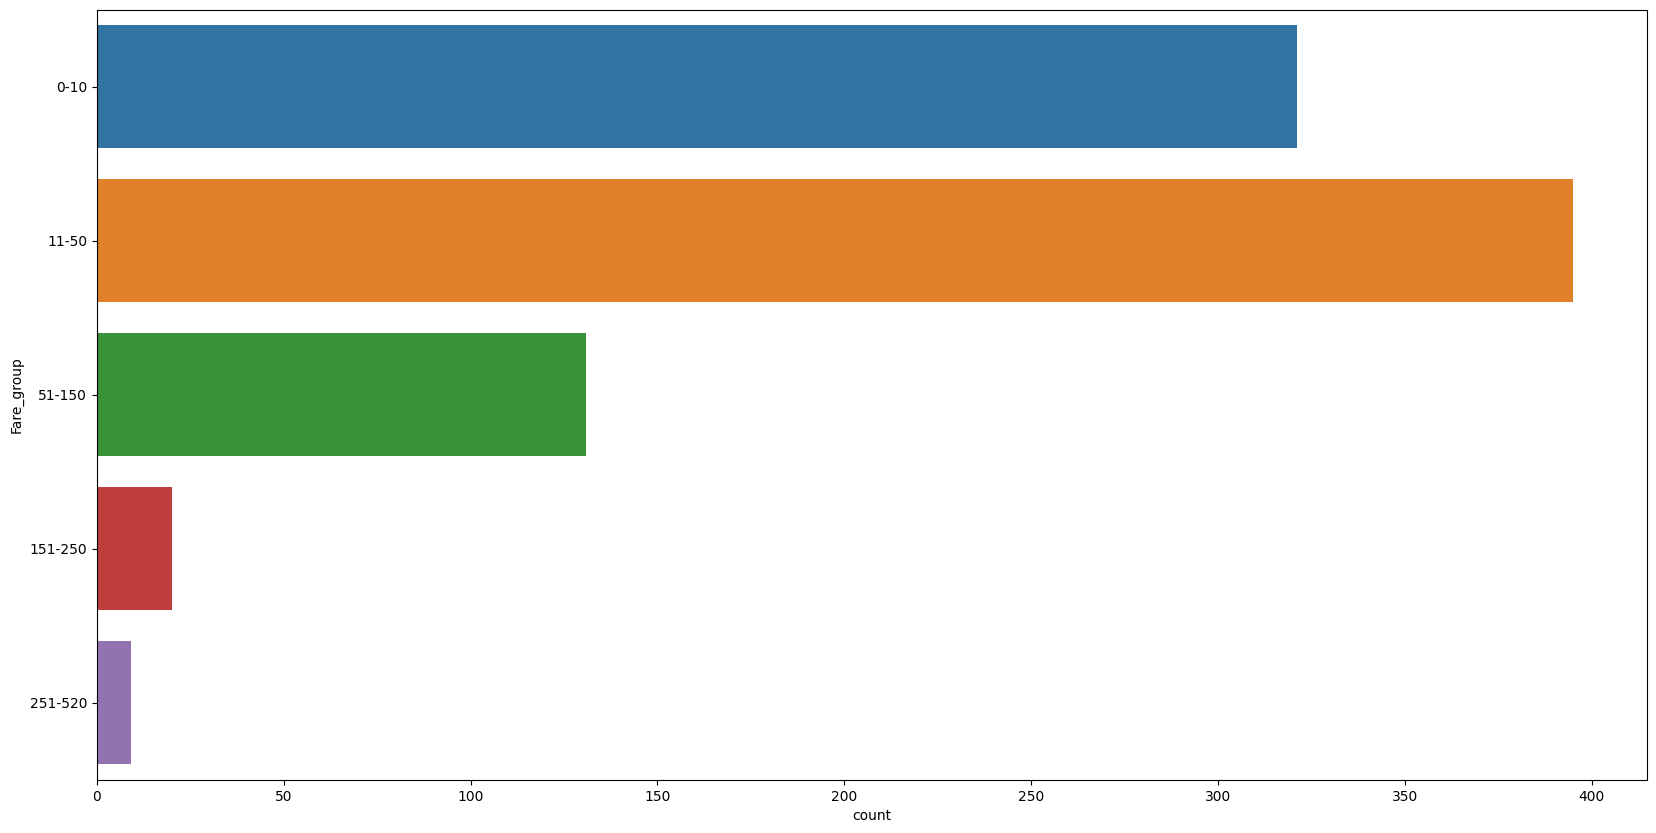

In [39]:
# Use a new df
fare_groups = titanic

fare_groups['Fare_group'] = pd.cut(fare_groups['Fare'], [0,10,50,150,250,520], 
                   labels=['0-10', '11-50', '51-150','151-250','251-520'])

fig = plt.figure(figsize=(20,10))
sns.countplot(y=fare_groups['Fare_group'], data=fare_groups)

# We can see that there is a significantly high proportion of fares costing 0 to 50. 

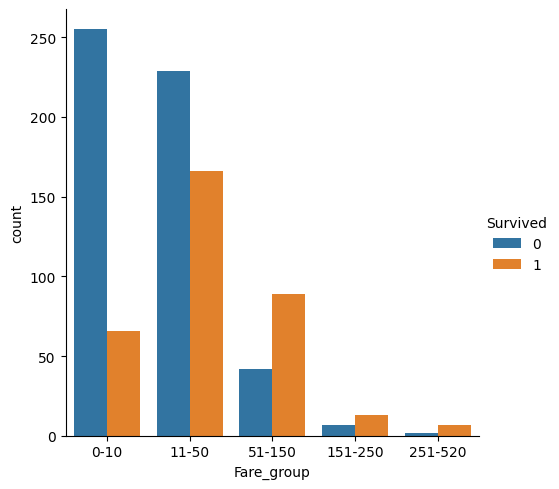

In [40]:
# Survival and Fare
sns.catplot(data=fare_groups, x="Fare_group", hue="Survived", kind="count")

# Revealing graph! Shows a much higher proportion of fares 0-10 did not survive. For fares 11-50 a higher proportion did not surive.
# However, for fares over 50, more people survived than perished.

<AxesSubplot: xlabel='Age', ylabel='Embarked'>

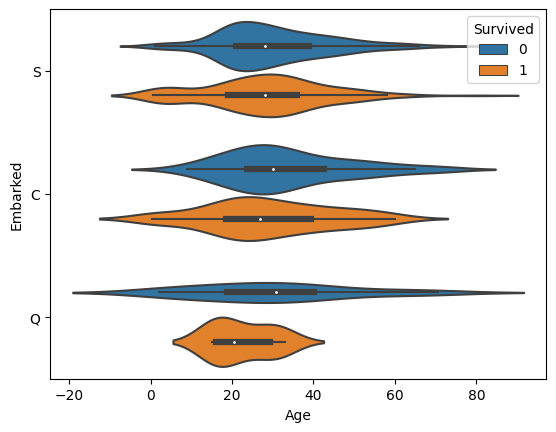

In [46]:
# Trying a violin plot to check if there is a link with embark town and survival
sns.violinplot(data=titanic, x="Age", y="Embarked", hue="Survived")

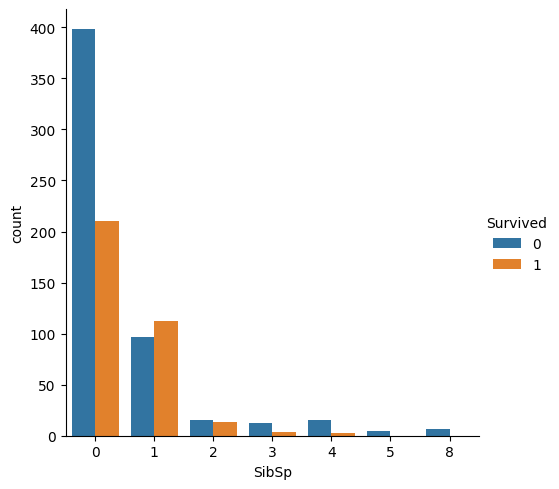

In [49]:
# Survival and sibling/spouse onboard

sns.catplot(data=titanic, x="SibSp", hue="Survived", kind="count")
# Only slightly more likely to survive if you had one sib/spouse onboard

c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 78.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 89.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

<AxesSubplot: xlabel='Age_group', ylabel='SibSp'>

c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 78.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 89.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3543: UserWarning: 89.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

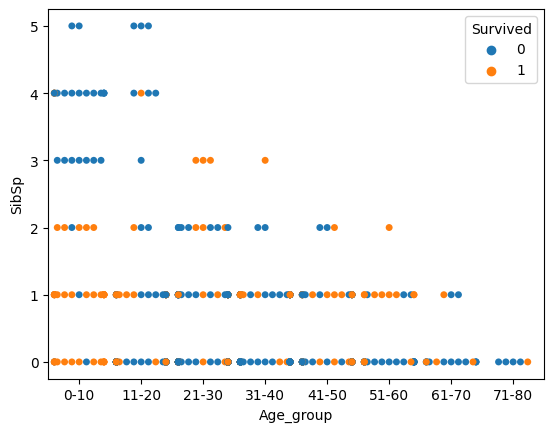

In [52]:
# Trying a swarmplot 
sns.swarmplot(data=with_ages, x="Age_group", y="SibSp", hue="Survived")



In [ ]:
# In conclusion, it appears that:
# Men were less likely to survive
# Children aged 0-10 were more likely to survive
# 2nd and espeically 1st class passengers were more likely to survive
# The most signicant factor for me was the fare price, those who spent 50+ were more likely to survive